# Compute metrics for different runs and plot them
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.1.0

```
conda create --name env-hurr-tfp python=3.9
conda activate env-hurr-tfp
pip install tensorflow==2.7.0
pip install tensorflow-probability==0.15.0
pip install --upgrade numpy scipy pandas statsmodels matplotlib seaborn 
pip install --upgrade palettable progressbar2 tabulate icecream flake8
pip install --upgrade keras-tuner sklearn
pip install --upgrade jupyterlab black isort jupyterlab_code_formatter
pip install silence-tensorflow
pip install tqdm
```

Use the command
```python -m pip freeze > requirements.txt```
to make a pip installation list.

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import shash
from build_data import build_hurricane_data
import build_model
import model_diagnostics
from silence_tensorflow import silence_tensorflow
import prediction
from sklearn.neighbors import KernelDensity
import pandas as pd
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

silence_tensorflow()
dpiFig = 400

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "21 January 2022"

EXP_NAME_LIST = (
                 "intensity0_EPCP72",
                 "intensity1_EPCP72",
                 "intensity2_EPCP72",
                 "intensity3_EPCP72",    
                )
APPEND_NAME = '_testYear_2018'


OVERWRITE_METRICS = False
DATA_PATH = "data/"
MODEL_PATH = "saved_models/"
METRIC_PATH = "model_metrics/"
FIGURE_PATH = "figures/summary_plots/"

In [3]:
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Define get_metrics()

In [4]:
def get_metrics():
    tf.random.set_seed(network_seed)
    shash_incs = np.arange(-160,161,1)

    if settings["uncertainty_type"] in ("bnn", "mcdrop", "reg"):       
        # loop through runs for bnn calculation    
        runs = 5_000
        bins_plot = np.linspace(np.min(shash_incs), np.max(shash_incs), 1000)
        bnn_cpd = np.zeros((np.shape(x_test)[0],runs))
        bnn_mode = np.zeros((np.shape(x_test)[0],))

        for i in tqdm(range(0,runs)):
            if settings["uncertainty_type"] == "bnn":
                bnn_cpd[:,i] = np.reshape(model.predict(x_test),np.shape(bnn_cpd)[0])
            elif settings["uncertainty_type"] in ("mcdrop", "reg"):
                bnn_cpd[:,i] = np.reshape(model(x_test,training=True),np.shape(bnn_cpd)[0])                
            else:
                raise NotImplementedError
                
        bnn_mean = np.mean(bnn_cpd,axis=1)
        bnn_median = np.median(bnn_cpd,axis=1)

        for j in tqdm(range(0,np.shape(bnn_mode)[0])):
            kde = KernelDensity(kernel="gaussian", bandwidth=4.).fit(bnn_cpd[j,:].reshape(-1,1))
            log_dens = kde.score_samples(bins_plot.reshape(-1,1))
            i = np.argmax(log_dens)
            bnn_mode[j] = bins_plot[i]

        mean_error, median_error, mode_error = model_diagnostics.compute_errors(onehot_test, bnn_mean, bnn_median, bnn_mode)         
        bins, hist_bnn, pit_D, EDp_bnn = model_diagnostics.compute_pit('bnn',onehot_test, bnn_cpd)
        iqr_capture = model_diagnostics.compute_interquartile_capture('bnn',onehot_test, bnn_cpd)
        iqr_error_spearman, iqr_error_pearson = model_diagnostics.compute_iqr_error_corr('bnn',
                                                                                          onehot_data=onehot_test, 
                                                                                          bnn_cpd=bnn_cpd, 
                                                                                          pred_median=bnn_median,
                                                                                         )
        
    elif settings["uncertainty_type"] in ("shash","shash2", "shash3", "shash4"):         
        shash_cpd = np.zeros((np.shape(x_test)[0],len(shash_incs)))
        shash_mean = np.zeros((np.shape(x_test)[0],))
        shash_med = np.zeros((np.shape(x_test)[0],))
        shash_mode = np.zeros((np.shape(x_test)[0],))

        # loop through samples for shash calculation and get PDF for each sample
        for j in tqdm(range(0,np.shape(shash_cpd)[0])):
            mu_pred, sigma_pred, gamma_pred, tau_pred = prediction.params( x_test[np.newaxis,j], model )
            shash_cpd[j,:] = shash.prob(shash_incs, mu_pred, sigma_pred, gamma_pred, tau_pred)    
            shash_mean[j]  = shash.mean(mu_pred,sigma_pred,gamma_pred,tau_pred)#np.sum(shash_cpd[j,:]*shash_incs)
            shash_med[j]   = shash.median(mu_pred,sigma_pred,gamma_pred,tau_pred)

            i = np.argmax(shash_cpd[j,:])
            shash_mode[j]  = shash_incs[i]

        mean_error, median_error, mode_error = model_diagnostics.compute_errors(onehot_test, shash_mean, shash_med, shash_mode)    
        bins, hist_shash, pit_D, EDp_shash = model_diagnostics.compute_pit('shash',onehot_test, x_data=x_test,model_shash=model)
        iqr_capture = model_diagnostics.compute_interquartile_capture('shash',onehot_test, x_data=x_test,model_shash=model)
        iqr_error_spearman, iqr_error_pearson = model_diagnostics.compute_iqr_error_corr('shash',
                                                                                                onehot_data=onehot_test,
                                                                                                pred_median=shash_med,
                                                                                                x_data=x_test,
                                                                                                model_shash=model,
                                                                                               )
    else:
        raise NotImplementedError
        
    # by definition Consensus is a correction of zero
    cons_error = np.mean(np.abs(0.0 - onehot_test[:,0]))
        
    return mean_error,median_error,mode_error,pit_D,iqr_capture,cons_error,iqr_error_spearman,iqr_error_pearson


## Evaluate the models

In [5]:
# raise ValueError('do not compute metrics yet')

In [6]:
import imp
imp.reload(model_diagnostics)

for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)
    RNG_SEED_LIST = np.copy(settings['rng_seed'])

    for rng_seed in RNG_SEED_LIST:
        settings['rng_seed'] = rng_seed
        NETWORK_SEED_LIST = [settings["rng_seed"]]
        network_seed = NETWORK_SEED_LIST[0]
        tf.random.set_seed(network_seed)  # This sets the global random seed.    

        #----------------------------------------------------------------------------------------------------
        # get the data
        (
            data_summary,
            x_train,
            onehot_train,
            x_val,
            onehot_val,
            x_test,
            onehot_test,    
            df_train,
            df_val,
            df_test,
        ) = build_hurricane_data(DATA_PATH, settings, verbose=0)

        #----------------------------------------------------------------------------------------------------
        # get the model
        # Make, compile, and train the model
        tf.keras.backend.clear_session()            
        model = build_model.make_model(
            settings,
            x_train,
            onehot_train,
            model_compile=False,
        )   
        model_name = (
            exp_name + "_" + 
            settings["uncertainty_type"] + '_' + 
            f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
        )
        
        try:
            model.load_weights(MODEL_PATH + model_name + "_weights.h5")
        except:
            print(model_name + ': model does not exist. skipping...')
            continue

        #----------------------------------------------------------------------------------------------------
        # check if the metric filename exists already
        metric_filename = METRIC_PATH + model_name + '_metrics.pkl'              
        if (os.path.exists(metric_filename) and OVERWRITE_METRICS==False):
            # print(metric_filename + ' exists. Skipping...')
            continue
            
        # get metrics and put into a dictionary
        pprint.pprint(model_name)
                
        # compute the metrics
        mean_error, median_error, mode_error, pit_D, iqr_capture, cons_error, iqr_error_spearman,iqr_error_pearson = get_metrics()        
        d = {'uncertainty_type': settings["uncertainty_type"],
             'network_seed': network_seed,
             'rng_seed': settings['rng_seed'],
             'exp_name': exp_name,
             'mean_error': mean_error,
             'median_error': median_error,
             'mode_error': mode_error,
             'cons_error': cons_error,
             'pit_d': pit_D,
             'iqr_capture': iqr_capture,
             'iqr_error_spearman': iqr_error_spearman[0],
             'iqr_error_pearson': iqr_error_pearson[0],             
             'iqr_error_spearman_p': iqr_error_spearman[1],
             'iqr_error_pearson_p': iqr_error_pearson[1],             
        }
        pprint.pprint(d, width=80)  
        df = pd.DataFrame(data=d, index=[0])
        df.to_pickle(metric_filename)

'intensity1_EPCP72_shash3_network_seed_786_rng_seed_786'


100%|███████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:09<00:00, 31.65it/s]


{'cons_error': 16.163897,
 'exp_name': 'intensity1_EPCP72',
 'iqr_capture': 0.476038338658147,
 'iqr_error_pearson': 0.2551579555987234,
 'iqr_error_pearson_p': 4.8298678092678536e-06,
 'iqr_error_spearman': 0.30555520769903866,
 'iqr_error_spearman_p': 3.454466304258062e-08,
 'mean_error': 13.95770891967673,
 'median_error': 14.51717509581639,
 'mode_error': 16.43290733843566,
 'network_seed': 786,
 'pit_d': 0.033812639246740266,
 'rng_seed': 786,
 'uncertainty_type': 'shash3'}
'intensity1_EPCP72_shash3_network_seed_311_rng_seed_311'


100%|███████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:09<00:00, 32.26it/s]


{'cons_error': 16.163897,
 'exp_name': 'intensity1_EPCP72',
 'iqr_capture': 0.3993610223642173,
 'iqr_error_pearson': 0.28630829659945267,
 'iqr_error_pearson_p': 2.559100594888029e-07,
 'iqr_error_spearman': 0.32774019188113324,
 'iqr_error_spearman_p': 2.850630725473718e-09,
 'mean_error': 14.715510229428356,
 'median_error': 15.133120266678995,
 'mode_error': 16.393929698691963,
 'network_seed': 311,
 'pit_d': 0.038392770121957374,
 'rng_seed': 311,
 'uncertainty_type': 'shash3'}
intensity1_EPCP72_shash3_network_seed_888_rng_seed_888: model does not exist. skipping...
intensity1_EPCP72_shash3_network_seed_999_rng_seed_999: model does not exist. skipping...
intensity1_EPCP72_shash3_network_seed_578_rng_seed_578: model does not exist. skipping...
intensity1_EPCP72_shash3_network_seed_331_rng_seed_331: model does not exist. skipping...
intensity1_EPCP72_shash3_network_seed_908_rng_seed_908: model does not exist. skipping...
intensity1_EPCP72_shash3_network_seed_444_rng_seed_444: model 

In [7]:
# raise ValueError('do not plot yet')

In [8]:
df_metrics = pd.DataFrame()

for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)
    RNG_SEED_LIST = np.copy(settings['rng_seed'])
    
    for rng_seed in RNG_SEED_LIST:
        settings['rng_seed'] = rng_seed
        NETWORK_SEED_LIST = [settings["rng_seed"]]
        network_seed = NETWORK_SEED_LIST[0]
    
        model_name = (
                exp_name + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
        )
        
        # load the metric filename
        metric_filename = METRIC_PATH + model_name + '_metrics.pkl'  
        if os.path.exists(metric_filename)==False:
            print(metric_filename + ' DOES NOT exist. Skipping...')
            continue
    
        # pprint.pprint(model_name)
        df = pd.read_pickle(metric_filename)
        df['basin_lead'] = exp_name[exp_name.rfind('_')+1:]
        df['mean_error_reduction'] = df['cons_error']-df['mean_error']
        df['median_error_reduction'] = df['cons_error']-df['median_error']        
        df['mode_error_reduction'] = df['cons_error']-df['mode_error']        
        df_metrics = pd.concat([df_metrics,df])
df_metrics

model_metrics/intensity1_EPCP72_shash3_network_seed_888_rng_seed_888_metrics.pkl DOES NOT exist. Skipping...
model_metrics/intensity1_EPCP72_shash3_network_seed_999_rng_seed_999_metrics.pkl DOES NOT exist. Skipping...
model_metrics/intensity1_EPCP72_shash3_network_seed_578_rng_seed_578_metrics.pkl DOES NOT exist. Skipping...
model_metrics/intensity1_EPCP72_shash3_network_seed_331_rng_seed_331_metrics.pkl DOES NOT exist. Skipping...
model_metrics/intensity1_EPCP72_shash3_network_seed_908_rng_seed_908_metrics.pkl DOES NOT exist. Skipping...
model_metrics/intensity1_EPCP72_shash3_network_seed_444_rng_seed_444_metrics.pkl DOES NOT exist. Skipping...
model_metrics/intensity2_EPCP72_bnn_network_seed_605_rng_seed_605_metrics.pkl DOES NOT exist. Skipping...
model_metrics/intensity2_EPCP72_bnn_network_seed_122_rng_seed_122_metrics.pkl DOES NOT exist. Skipping...
model_metrics/intensity2_EPCP72_bnn_network_seed_786_rng_seed_786_metrics.pkl DOES NOT exist. Skipping...
model_metrics/intensity2_EPC

,uncertainty_type,network_seed,rng_seed,exp_name,mean_error,median_error,mode_error,cons_error,pit_d,iqr_capture,iqr_error_spearman,iqr_error_pearson,iqr_error_spearman_p,iqr_error_pearson_p,basin_lead,mean_error_reduction,median_error_reduction,mode_error_reduction
0,reg,605,605,intensity0_EPCP72,13.693099,13.693099,13.686995,16.163897,0.203552,0.000000,NaN,NaN,NaN,NaN,EPCP72,2.470798,2.470798,2.476901
0,reg,122,122,intensity0_EPCP72,13.746249,13.746249,13.746704,16.163897,0.205002,0.000000,NaN,NaN,NaN,NaN,EPCP72,2.417647,2.417647,2.417192
0,reg,786,786,intensity0_EPCP72,13.825076,13.825076,13.825268,16.163897,0.203292,0.000000,NaN,NaN,NaN,NaN,EPCP72,2.338820,2.338820,2.338629
0,reg,311,311,intensity0_EPCP72,13.478027,13.478027,13.478221,16.163897,0.203552,0.000000,NaN,NaN,NaN,NaN,EPCP72,2.685870,2.685870,2.685676
0,reg,888,888,intensity0_EPCP72,13.970870,13.970870,13.964232,16.163897,0.205648,0.000000,NaN,NaN,NaN,NaN,EPCP72,2.193027,2.193027,2.199665
0,reg,999,999,intensity0_EPCP72,13.808915,13.808915,13.807702,16.163897,0.202133,0.000000,NaN,NaN,NaN,NaN,EPCP72,2.354981,2.354981,2.356195
0,reg,578,578,intensity0_EPCP72,14.340648,14.340648,14.344097,16.163897,0.205985,0.000000,NaN,NaN,NaN,NaN,EPCP72,1.823249,1.823249,1.819799
0,reg,331,331,intensity0_EPCP72,13.459407,13.459407,13.458240,16.163897,0.202799,0.000000,NaN,NaN,NaN,NaN,EPCP72,2.704489,2.704489,2.705657
0,reg,908,908,intensity0_EPCP72,12.849200,12.849200,12.851507,16.163897,0.202567,0.000000,NaN,NaN,NaN,NaN,EPCP72,3.314696,3.314696,3.312389
0,reg,444,444,intensity0_EPCP72,13.243539,13.243539,13.245141,16.163897,0.203823,0.000000,NaN,NaN,NaN,NaN,EPCP72,2.920357,2.920357,2.918755


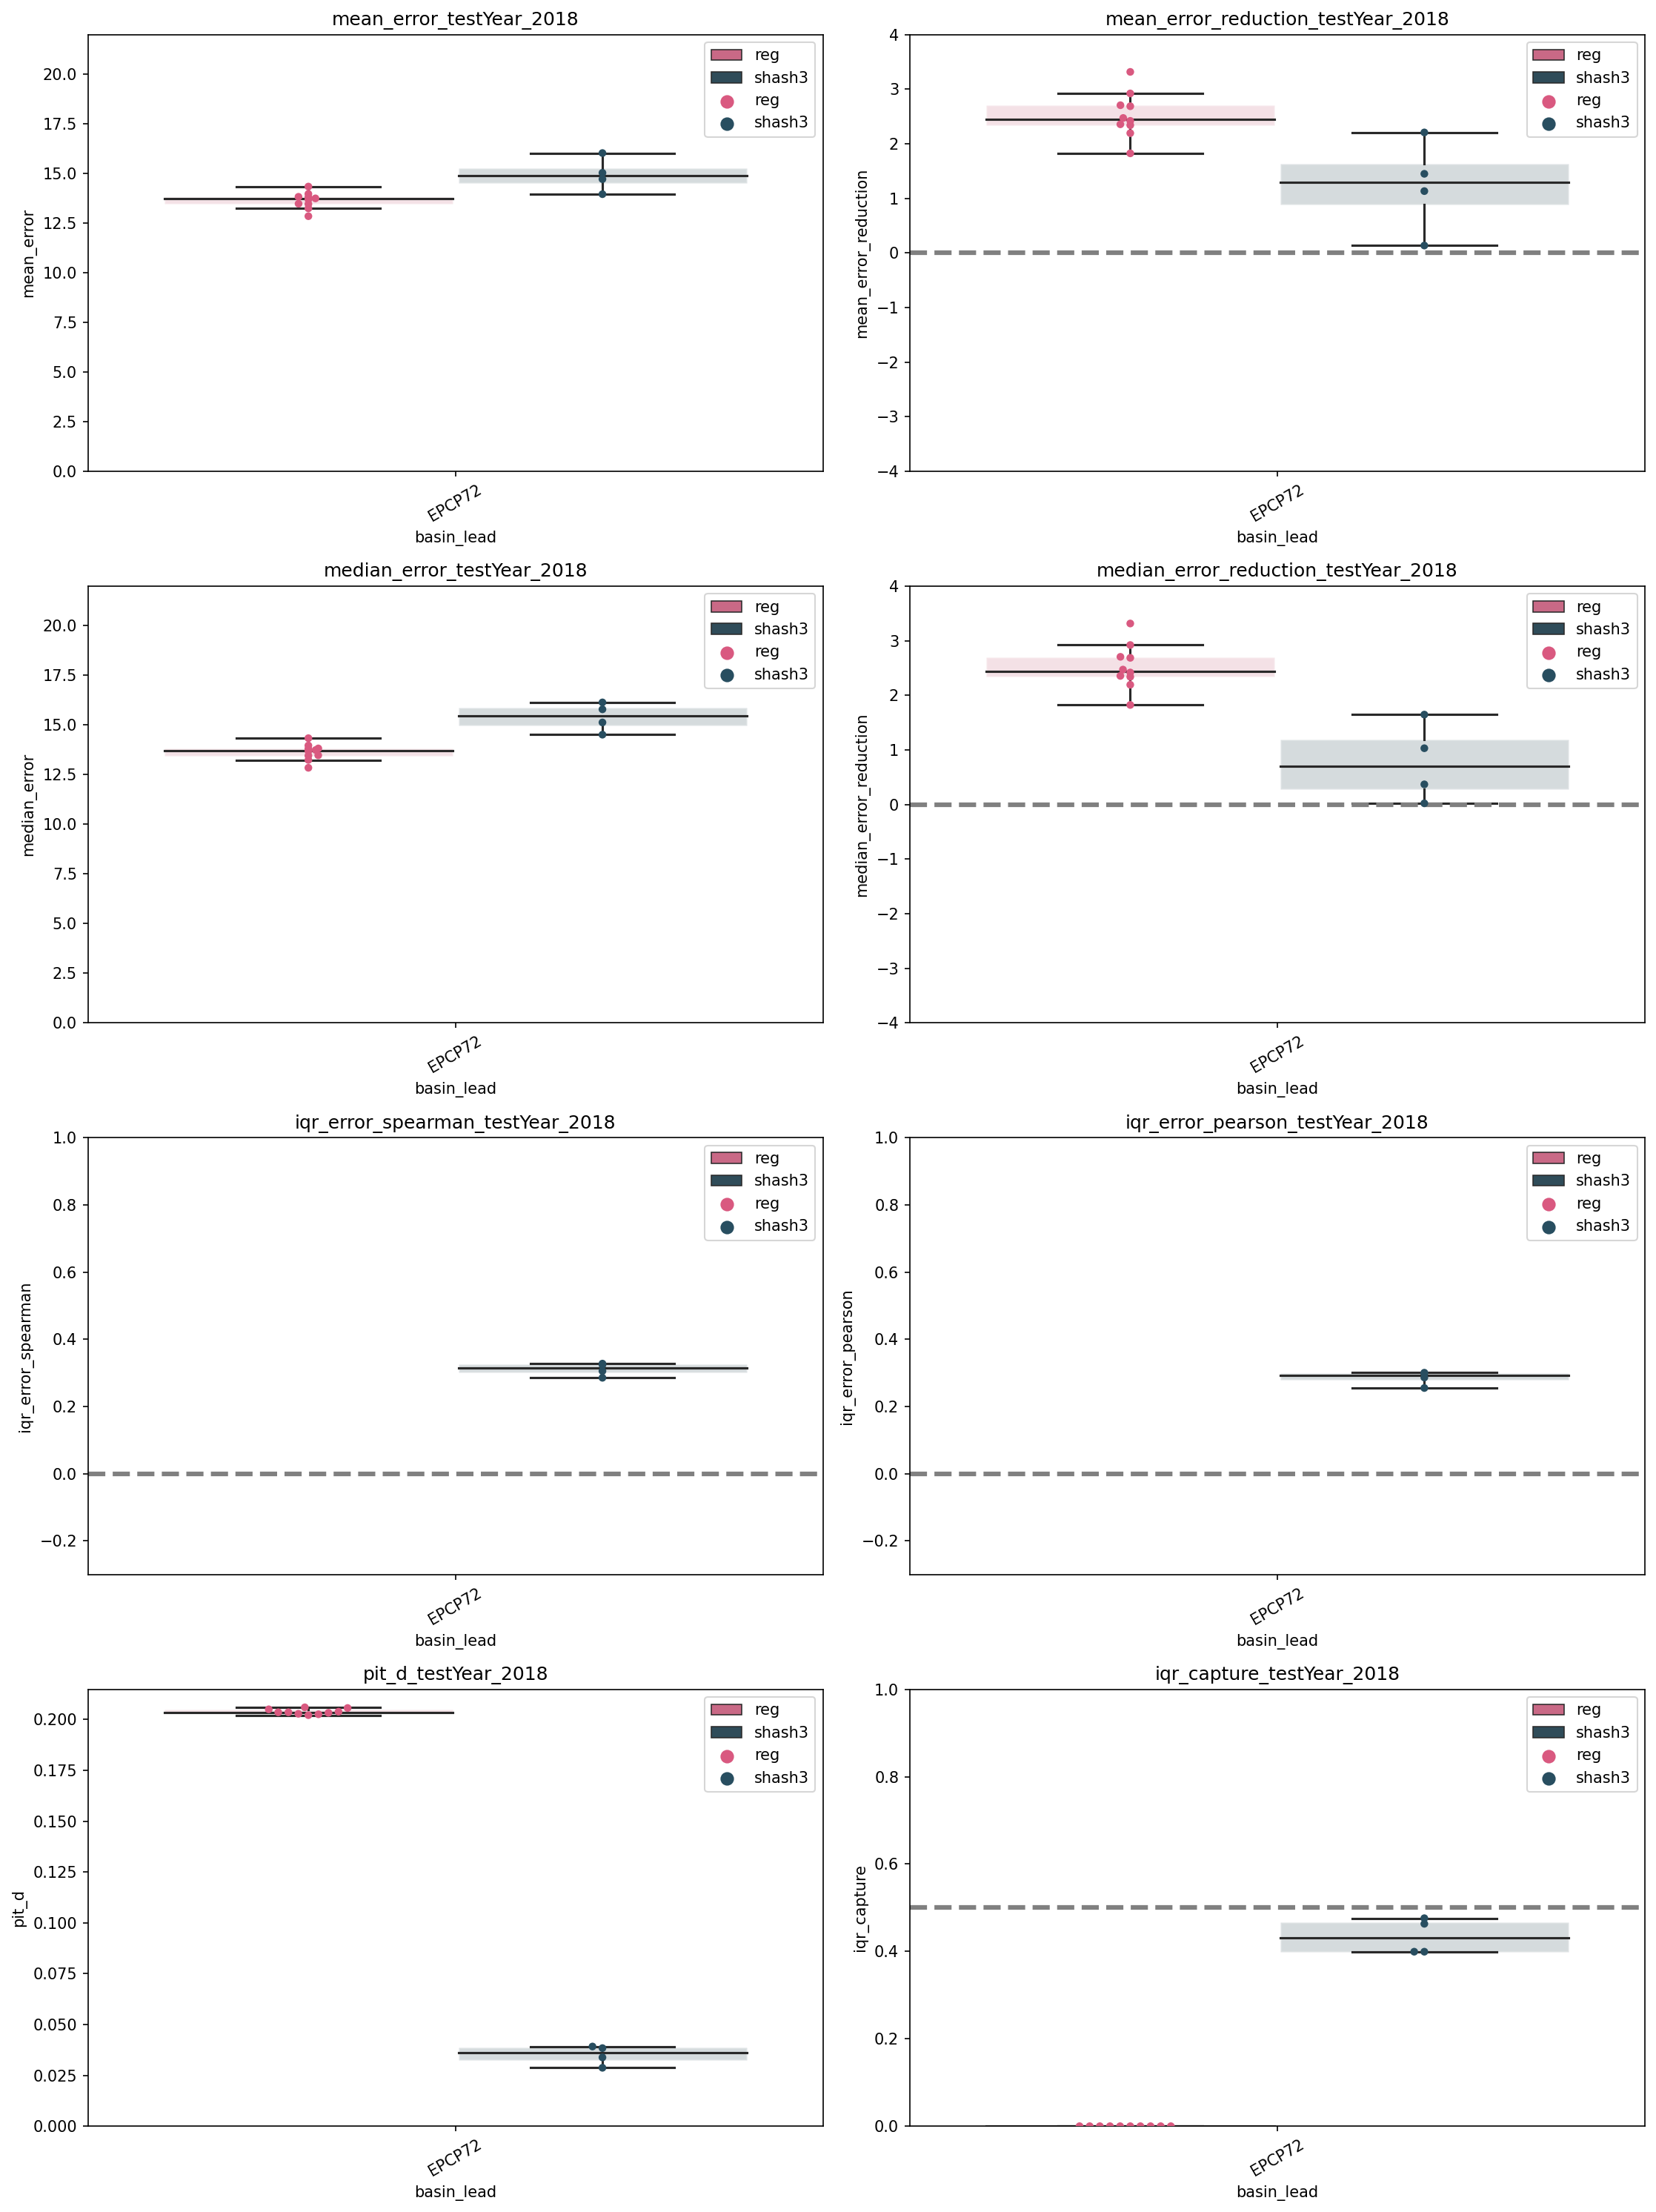

In [9]:
import seaborn as sns
colors = ('#D95980','#284E60','#E1A730','#C3B1E1')

x_axis_list = ("basin_lead",)#("basin_lead", "exp_name")

for x_axis in x_axis_list:
    f, axs = plt.subplots(4, 2, figsize=(15,20))
    axs = axs.flatten()
    
    for imetric, metric in enumerate(('mean_error',
                                      'mean_error_reduction',
                                      'median_error',
                                      'median_error_reduction',                                  
                                      'iqr_error_spearman',
                                      'iqr_error_pearson',                                  
                                      # 'mode_error',
                                      # 'mode_error_reduction',                                  
                                      'pit_d',
                                      'iqr_capture')):
        ax = axs[imetric]
        g1 = sns.boxplot(x=x_axis, 
                         y=metric, 
                         hue="uncertainty_type",
                         data=df_metrics,
                         palette=colors,
                         boxprops={'alpha':.2,
                                   'edgecolor': 'white',
                                  },
                         fliersize=0,
                         ax=ax)
        g2 = sns.swarmplot(x=x_axis, 
                           y=metric, 
                           hue="uncertainty_type",
                           palette=colors,
                           data=df_metrics, 
                           dodge=True,
                           ax=ax)

        if(metric=='iqr_capture'):
            ax.axhline(y=0.5,linewidth=3,linestyle='--',color='gray')
            ax.set_ylim(0,1.0)
        if(metric=='pit_d'):
            ax.set_ylim(0,None)
        if(metric.find('reduction') > -1):
            ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')
            ax.set_ylim(-4.,4.)
        if(metric.find('reduction') == -1 and metric.find('n_error') > -1):
            ax.set_ylim(0.,22.)
        if(metric.find('iqr_error')> -1):
            ax.set_ylim(-.3,1.)
            ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')        


        ax.set_title(metric + APPEND_NAME)
        ax.legend(fontsize=10,frameon=True)
        ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

    plt.tight_layout()    
    plt.savefig(FIGURE_PATH + 'comparisonsMetrics' + APPEND_NAME + '_' + x_axis + '.png', dpi=dpiFig)    
    # plt.close()
    plt.show()